### **Trabajo Final para la Cátedra de Fundamentos de Analítica I**
#### El objetivo del presente proyecto es la supervivencia en el Titanic, así como establecer una caracterización de los sobrevivientes y de aquellos que tuvieron el mismo final que Jack.

##### Realizado por:
  - Claudia Lorena Aragón 
  - Álvaro José Cabrera
  - Álvaro Rodríguez Lasso
  - Alfredo Aponte Segura

In [1]:
# Import de librarias necesarias para el proyecto
import pandas as pd
import sklearn
import seaborn as sns
import numpy as np
import missingno as msno
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from scipy.stats import randint
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

#  Visualization
import graphviz
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')


# Funciones para análisis de atípicos
from scipy.stats import skew, kurtosis  ## funciones estadísticas
def tabla_descriptivas(columnas):
    tabla_descriptivas=pd.DataFrame(columnas.describe())
    tabla_descriptivas.loc['coef. variation 0.30 | 0.30-0.70 | 0.70']=columnas.std()/columnas.mean()
    tabla_descriptivas.loc['skew < 0 sesgo izquierda | > 0 sesgo derecha ']=skew(columnas) #Sesgo o asimetría
    tabla_descriptivas.loc['kurtosis <0 achatada platicurtica | > 0 empinada leptocurtica']=kurtosis(columnas)
    q1=columnas.quantile(0.25)
    q3=columnas.quantile(0.75)
    IQR=q3-q1
    outliers = columnas[ ((columnas<(q1-1.5*IQR)) | (columnas>(q3+1.5*IQR))) ]
    outlier_minimos = columnas[columnas<(q1-1.5*IQR)]
    outlier_maximos = columnas[columnas>(q3+1.5*IQR)]
    tabla_descriptivas.loc['Umbral atípicos minimo']=  columnas.quantile(0.25) - (columnas.quantile(0.75) - columnas.quantile(0.25))*1.5
    tabla_descriptivas.loc['Umbral atípicos maximo']=  columnas.quantile(0.75) + (columnas.quantile(0.75) - columnas.quantile(0.25))*1.5
    #tabla_descriptivas.loc['cantidad atipicos minimos']=   len(outlier_minimos)
    #tabla_descriptivas.loc['cantidad atipicos maximos']= len(outlier_maximos)
    #tabla_descriptivas.loc['cantidad_total_atípicos']= len(outliers)
    return tabla_descriptivas

### 1. Limpieza y EDA

#### Cargue de datos

In [2]:
df_completo = pd.read_csv("train.csv") #Dataset completo
#Split de datasets para generar un set de test por python, dado que no hay etiquetas en el set de test de Kaggle.
df_train, df_test = train_test_split(df_completo, test_size=0.2, random_state=42) 
df_train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
331,332,0,1,"Partner, Mr. Austen",male,45.5,0,0,113043,28.500,C124,S
733,734,0,2,"Berriman, Mr. William John",male,23.0,0,0,28425,13.000,NaN,S
382,383,0,3,"Tikkanen, Mr. Juho",male,32.0,0,0,STON/O 2. 3101293,7.925,NaN,S


#### Validación general de formatos del dataset, datos faltantes y duplicados

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 331 to 102
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          572 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        159 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


In [4]:
df_train.isnull().mean()*100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.662921
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.668539
Embarked        0.280899
dtype: float64

In [5]:
df_train.duplicated().sum()

0

Encontramos un data set de entrenamiento con 891 registros. Las variables se encuentran correctamente formateadas.  Sin embargo, la variable "Cabin", presenta un 77% de datos faltantes por lo que se descartará del análisis posteriormente.  Por otro lado las variables "Age" y "Embarked" presentan aproxidamente un 20% de datos faltantes, por lo que se deberán imputar. FInalmente, no se presentan valores duplicados.

#### Eliminación de variables innecesarias del dataset

In [6]:
df_train = df_train.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])
df_test = df_test.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])

Eliminamos variables cualitativas que no nos aportan en nuestro objetivo o presentan mayor proporción de valores nulos: "PassengerId", "Name", "Ticker", "Cabin".  Adicionalmente, la cabina se explica con la clase de la persona (multicolinealidad).

#### Análisis descriptivo

#### Distribución de las variables cuantitativas

In [7]:
tabla_descriptivas(df_train[['Age', 'SibSp','Parch','Fare']])

,Age,SibSp,Parch,Fare
count,572.000000,712.000000,712.000000,712.000000
mean,29.498846,0.553371,0.379213,32.586276
std,14.500059,1.176404,0.791669,51.969529
min,0.420000,0.000000,0.000000,0.000000
25%,21.000000,0.000000,0.000000,7.925000
50%,28.000000,0.000000,0.000000,14.454200
75%,38.000000,1.000000,0.000000,30.500000
max,80.000000,8.000000,6.000000,512.329200
coef. variation 0.30 | 0.30-0.70 | 0.70,0.491547,2.125888,2.087661,1.594829
skew < 0 sesgo izquierda | > 0 sesgo derecha,NaN,3.611755,2.689777,4.864789


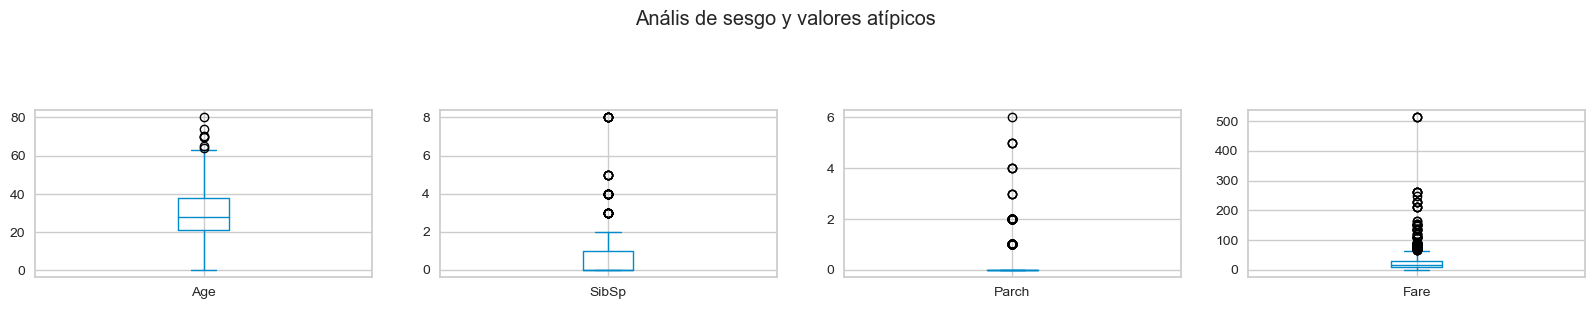

In [8]:
df_atipicos = df_train.drop(columns=['Pclass', 'Sex', 'Embarked', 'Survived'])
boxplot = df_atipicos.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False, figsize=(20,10), title='Anális de sesgo y valores atípicos', color="#008ACC" )
plt.show()

Age: 

-El 50% de la distribución de los datos se encuentra entre 20 y 38 años, con centro 28, es decir adultos jóvenes.

-Presenta unos cuantos atípicos de cara a edades máximas, superiores a 64 años. Son datos válidos.

Sibsp (nro. hermanos / cónyuges aboard the Titanic)

-El 50% de la distribución de los datos se encuentra entre 0 y 1, con centro 0.

-Presenta unos cuantos atípicos máximos superiores a 2.

Parch (Nro. de padres / hijos a bordo del Titanic)

-El 50% de la distribución de los datos se encuentra entre 0 y 0, con centro 0.

-Presenta unos cuantos atípicos máximo superiores a 0.

Fare (Tarifa)

-El 50% de la distribución de los datos se encuentra entre 7.91 y 31, con centro 14.4.

-Presenta una gran cantidad de datos atípicos, con valores superioes a 65.

#### Relación de variables cuantitativas Vs. variable objetivo y separación de tipo de variables

In [9]:
#Coerción y marcación de variables para graficar
df_train['Survived'] = df_train['Survived'].astype('category') # Asegúrarse de que la columna 'Survived' sea categórica para facilitar la visualización
df_test['Survived'] = df_test['Survived'].astype('category') # Asegúrarse de que la columna 'Survived' sea categórica para facilitar la visualización
df_train['Pclass'] = df_train['Pclass'].astype('category') # Asegúrarse de que la columna 'Survived' sea categórica para facilitar la visualización
df_test['Pclass'] = df_test['Pclass'].astype('category') # Asegúrarse de que la columna 'Survived' sea categórica para facilitar la visualización



# Separando las variables cuantitativas de las cualitativas
# Las variables cuantitativas son 'Age' y 'Fare'
quantitative_cols = ['Age', 'SibSp','Parch','Fare']
# Las variables cualitativas son 'Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked'
qualitative_cols = ['Pclass', 'Sex', 'Embarked']

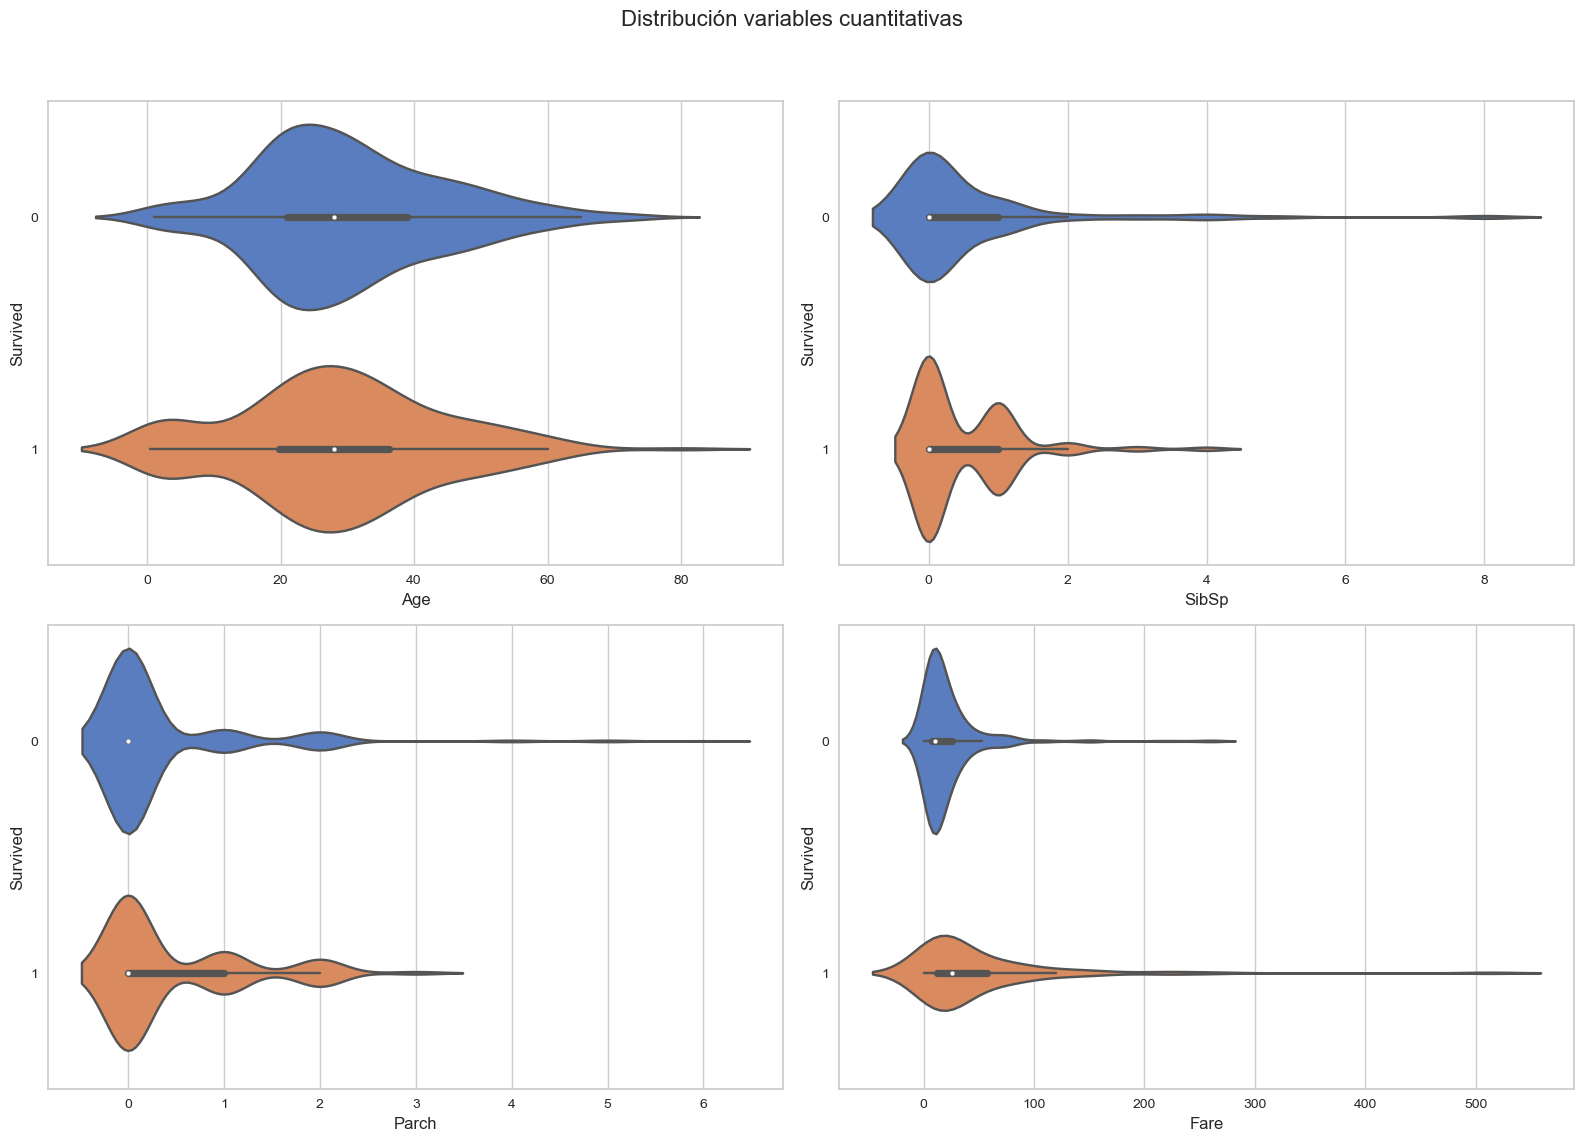

In [10]:
# Crear un tablero para gráficos de violín de variables cuantitativas
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
fig.suptitle('Distribución variables cuantitativas', fontsize=16)

for i, col in enumerate(quantitative_cols):
    ax = axes[i // 2, i % 2] # distribución del gráfico en la cuadrículas
    sns.violinplot(y='Survived', x=col, data=df_train, ax=ax, palette="muted")

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # espacios de los subplots
plt.show()

Edad:

Los sobrevivientes presentan una mayor frecuencia en edades bajas y menores frecuencias en edades muy avanzadas.

Sibsp (nro. hermanos / cónyuges aboard the Titanic):

Los sobrevivientes presentan dos grupos claramente identificables: sin sibsp o con 1 sibsp, estos últimos presentan mayor frecuencia que en los fallecidos.  En los fallecidos estos dos grupos no se ven tan claramente, además que presentan datos atípicos máximos: lo anterior implica que en el test de entrenamiento no se salvaron familias numerosas.

Parch (Nro. de padres / hijos a bordo del Titanic)

En los sobrevivientes existe más frecuencia en los valores 1 y 2

Fare (Tarifa)

Los sobrevivientes tienen su centro de distribución un poco más arriba que los fallecidos.   Adicionalmente, en los sobrevivientes se observa datos atípicos con valores muy altos.

#### Análisis visual de correlación 

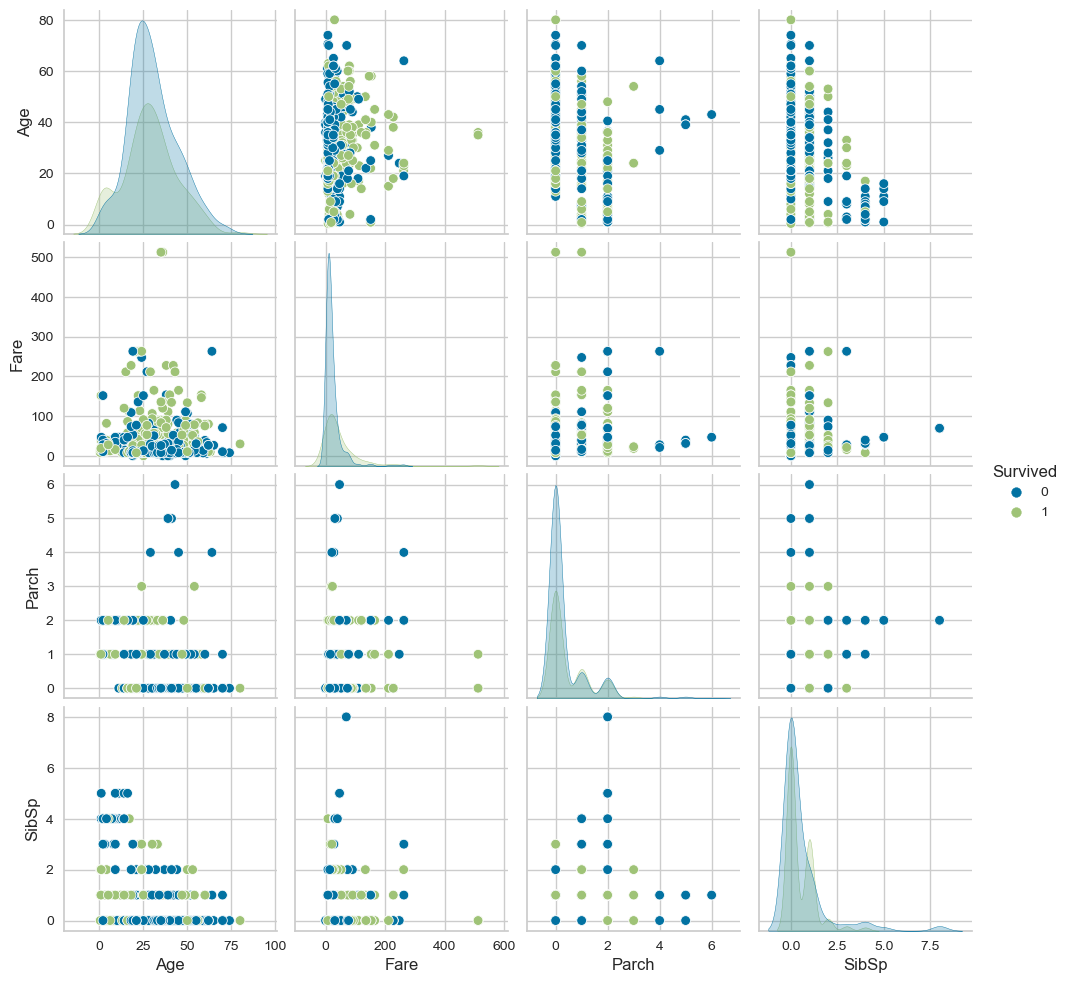

In [11]:
palette = {0: "red", 1: "green"}
sns.pairplot(data=df_train[['Age', 'Fare', 'Parch', 'SibSp','Survived']], hue="Survived")

#### Análisis de variables cualitativas

In [12]:
""""
# Visualización de variables cualitativas vs Survived
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
fig.suptitle('', fontsize=16)

for i, col in enumerate(qualitative_cols):
    ax = axes[i]
    sns.countplot(x=col, hue='Survived', data=df_train, ax=ax, palette="muted")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
"""

'"\n# Visualización de variables cualitativas vs Survived\nfig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))\nfig.suptitle(\'\', fontsize=16)\n\nfor i, col in enumerate(qualitative_cols):\n    ax = axes[i]\n    sns.countplot(x=col, hue=\'Survived\', data=df_train, ax=ax, palette="muted")\n\nplt.tight_layout(rect=[0, 0.03, 1, 0.95])\nplt.show()\n'

PClass1:  la clase mayoritaría son los sobrevivientes.

PClass2:  la clase de fallecidos, está un poco por encima de sobrevivientes. 

PClass3:  la clase de fallecidos es la mayoritaria.

Male: la clase mayoritaria es fallecidos.

Famale: la clase mayoritaria es sobreviviente.

Southampton (S , clase media y alta 50%, clase baja  50%): la clase mayoritaria es fallecidos.

Cherbourg (C, mayoritariamente clase alta 1): la clase mayoritaria es sobreviviente.

Queenstown (Q, mayoritariamente clase baja 3):  la clase mayoritaria  es fallecidos.

#### Label encoding

In [13]:
mapping_pclass   = {'1': 'Upper', '2': 'Middle', '3': 'Lower'}
mapping_survived = {'1': 'Survived', '0': 'No'}

# Reemplazar los valores en la columna 'Pclass'
df_train['Pclass'] = df_train['Pclass'].replace(mapping_pclass)
df_test['Pclass'] = df_test['Pclass'].replace(mapping_pclass)

df_train['Survived'] = df_train['Survived'].replace(mapping_survived)
df_test['Survived'] = df_test['Survived'].replace(mapping_survived)

#### Visualización de datos faltantes previo a imputación

<Axes: >

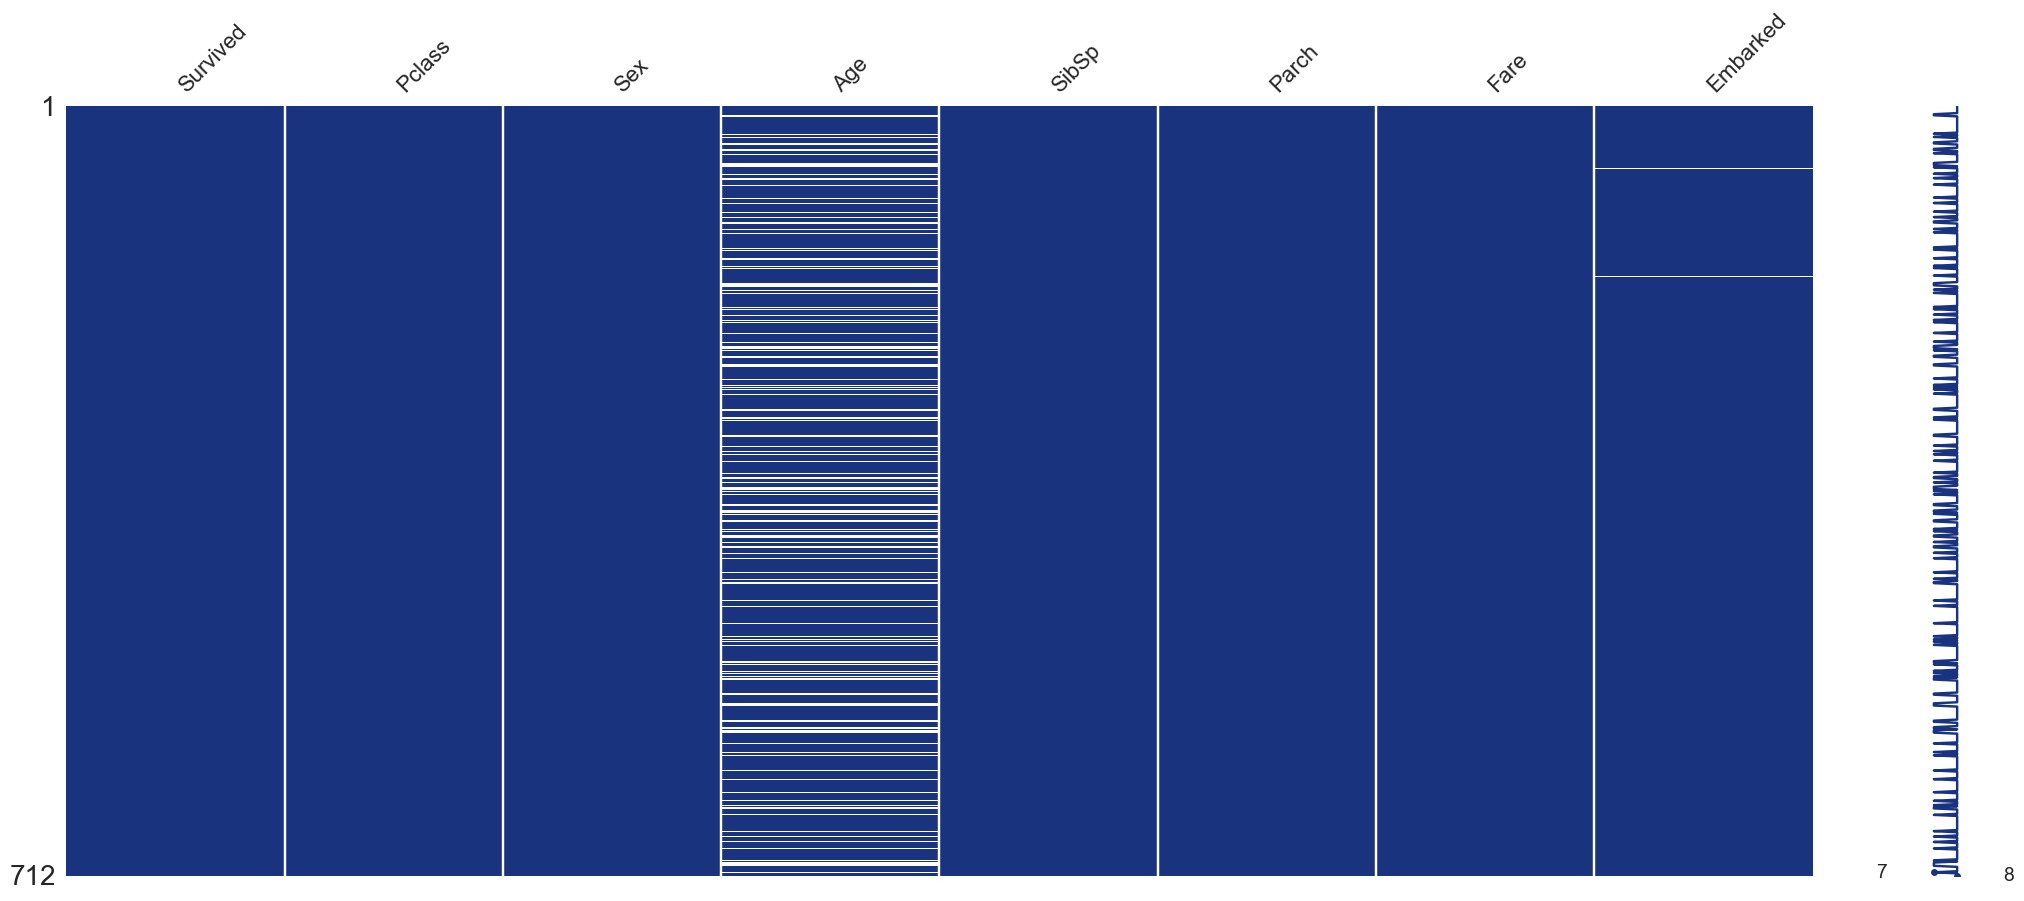

In [14]:
msno.matrix(df_train, color = (0.1, 0.2, 0.5)) #print(msno.matrix(df_train))

#### Imputación

<Axes: >

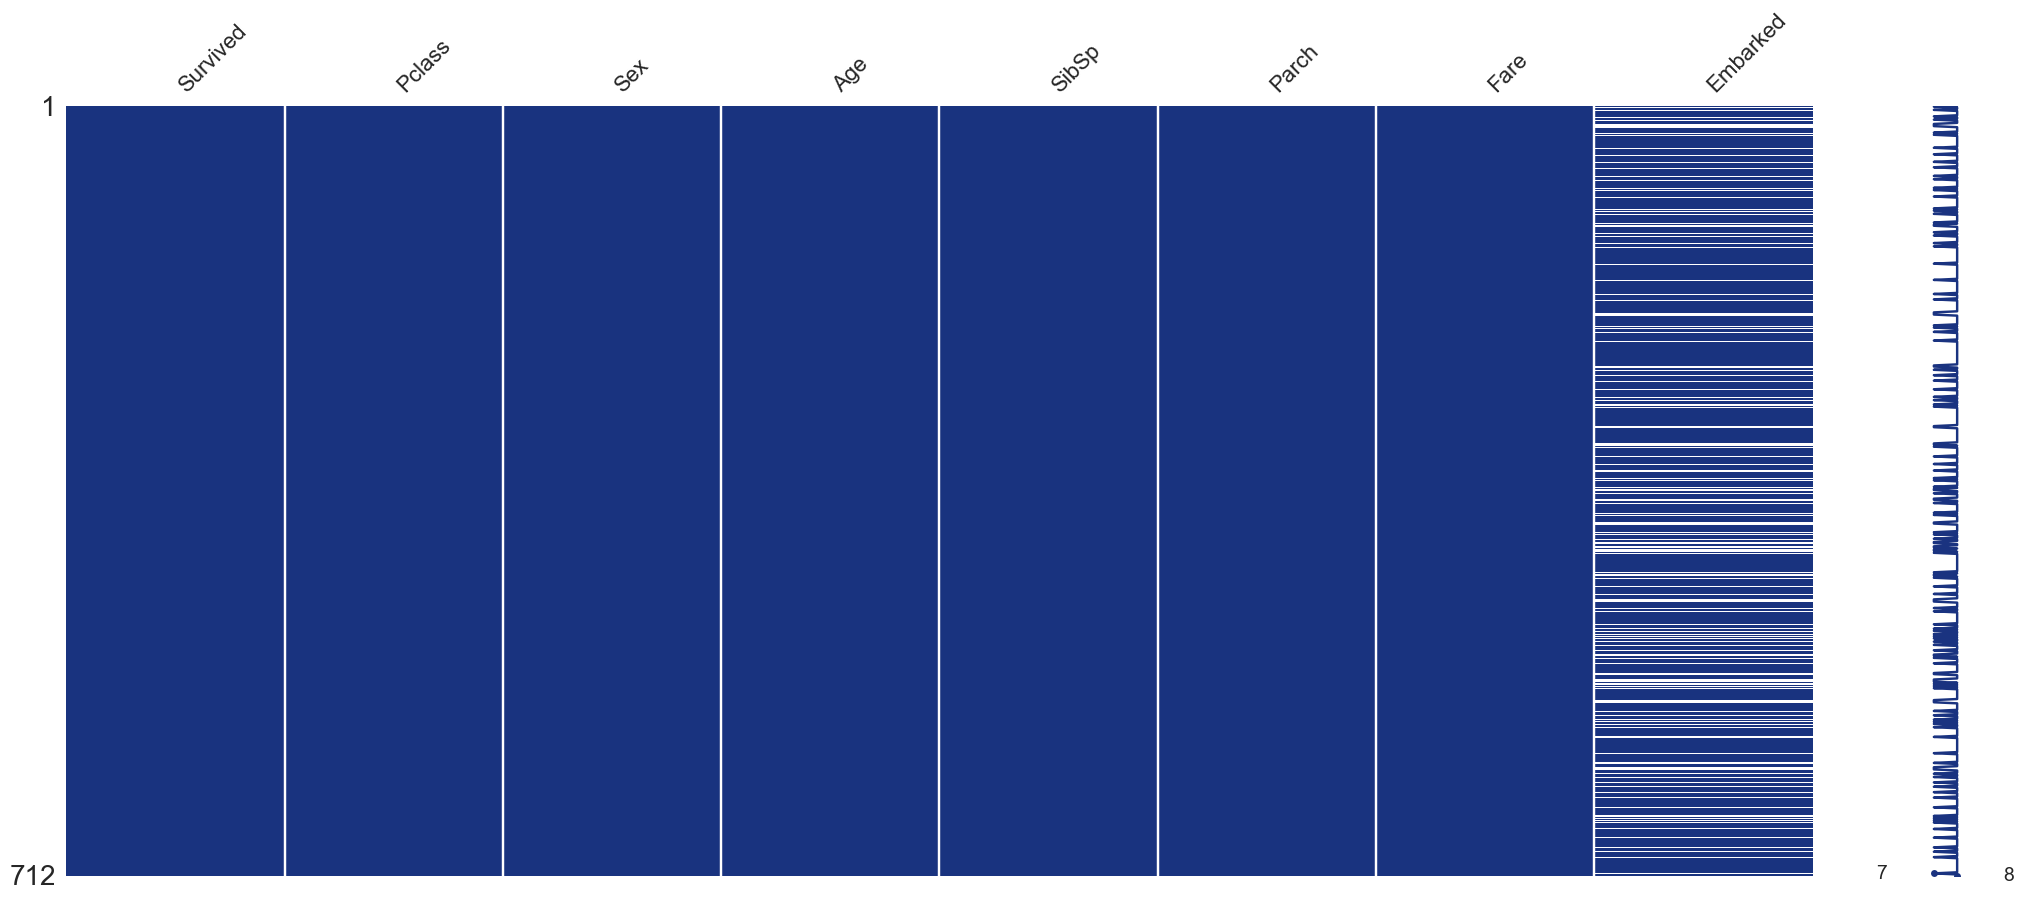

In [15]:
# Imputación #
imputer = SimpleImputer(strategy='most_frequent')
df_imputed = pd.DataFrame(imputer.fit_transform(df_train[['Embarked']]), columns=['Embarked'])
df_train['Embarked']=df_imputed['Embarked']


# Crea el objeto KNNImputer con 5 vecinos
knn_imputer = KNNImputer(n_neighbors=5)

# Imputación de las variables cuantitativas
# Se imputan los valores faltantes de las columnas 'Age' y 'Fare' utilizando KNNImputer
df_train[quantitative_cols] = knn_imputer.fit_transform(df_train[quantitative_cols])

#-----------------------------------------------------------------------------------------

#### Segundo datasets
# Imputación #
df_imputed2 = pd.DataFrame(imputer.fit_transform(df_test[['Embarked']]), columns=['Embarked'])
df_test['Embarked']=df_imputed2['Embarked']


# Crea el objeto KNNImputer con 5 vecinos
knn_imputer = KNNImputer(n_neighbors=5)

# Imputación de las variables cuantitativas
# Se imputan los valores faltantes de las columnas 'Age' y 'Fare' utilizando KNNImputer
df_test[quantitative_cols] = knn_imputer.fit_transform(df_test[quantitative_cols])

# Visualiza la matriz de valores faltantes después de la imputación
msno.matrix(df_train, color = (0.1, 0.2, 0.5))

Se observa que los valores han sido correctamente imputados

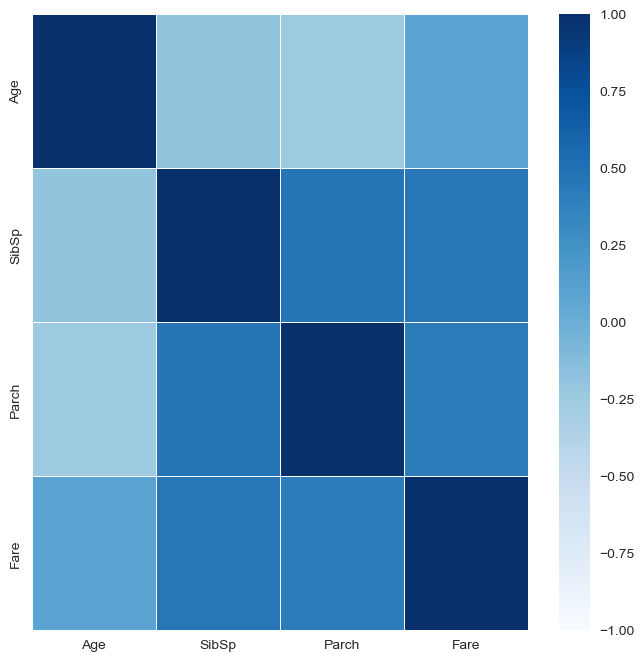

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked'],
      dtype='object')

In [16]:
# Calcular la matriz de correlación de Spearman
corr_matrix = df_train[quantitative_cols].corr(method='spearman')

# Crear un heatmap de la matriz de correlación
plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, cmap='Blues', vmin=-1, vmax=1, linewidths=0.5, linecolor='white')
plt.show()
df_train.columns

In [17]:
#Selección de matriz de entrenamiento y de prueba
X_train=df_train[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]
X_test=df_test[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]
y_train=df_train.iloc[:,0]
y_test=df_test.iloc[:,0]
y_train = y_train.replace({'No': 0, 'Survived': 1})
y_test = y_test.replace({'No': 0, 'Survived': 1})

In [18]:
# One-hot encode the categorical columns
X_train_encoded = pd.get_dummies(X_train[qualitative_cols], columns=qualitative_cols, drop_first=True)
X_test_encoded = pd.get_dummies(X_test[qualitative_cols], columns=qualitative_cols, drop_first=True)
# Combine the encoded categorical columns with the numerical columns
X_train_final = pd.concat([X_train_encoded, X_train.drop(columns=qualitative_cols)], axis=1)
X_test_final = pd.concat([X_test_encoded, X_test.drop(columns=qualitative_cols)], axis=1)
X_test_final

,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Age,SibSp,Parch,Fare
709,0,1,1,0,0,23.8,1.0,1.0,15.2458
439,1,0,1,0,0,31.0,0.0,0.0,10.5000
840,0,1,1,0,0,20.0,0.0,0.0,7.9250
720,1,0,0,0,0,6.0,0.0,1.0,33.0000
39,0,1,0,0,1,14.0,1.0,0.0,11.2417
...,...,...,...,...,...,...,...,...,...
433,0,1,1,0,0,17.0,0.0,0.0,7.1250
773,0,1,1,0,0,23.2,0.0,0.0,7.2250
25,0,1,0,0,1,38.0,1.0,5.0,31.3875
84,1,0,0,0,0,17.0,0.0,0.0,10.5000


### 2. Modelos predictivos 

#### 2.1 Regresion Logistica

In [19]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=16)

# fit the model with data
logreg.fit(X_train_final, y_train)

y_pred = logreg.predict(X_test_final)

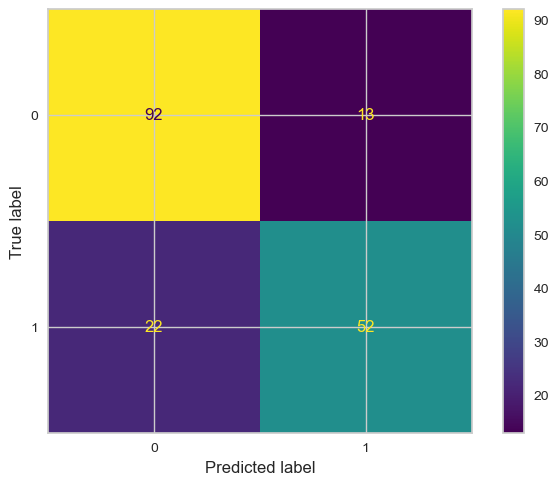

In [20]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cnf_matrix).plot()

In [21]:
target_names = ['No', 'Survived']
print(classification_report(y_test, y_pred, target_names=target_names))


              precision    recall  f1-score   support

          No       0.81      0.88      0.84       105
    Survived       0.80      0.70      0.75        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



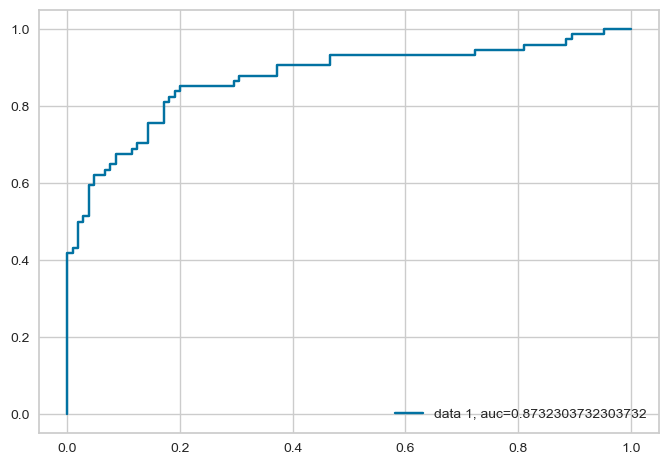

In [22]:
y_pred_proba = logreg.predict_proba(X_test_final)[::,1]

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

#### 2.2 Random Forest

In [23]:
rf = RandomForestClassifier()
rf.fit(X_train_final, y_train)
y_pred = rf.predict(X_test_final)
accuracy = accuracy_score(y_test, y_pred)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(cnf_matrix)
print(classification_report(y_test, y_pred, target_names=target_names))

[[93 12]
 [23 51]]
              precision    recall  f1-score   support

          No       0.80      0.89      0.84       105
    Survived       0.81      0.69      0.74        74

    accuracy                           0.80       179
   macro avg       0.81      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



In [24]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train_final, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000029CCA3A0D60>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000029CC9FA23B0>})

In [25]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 11, 'n_estimators': 69}


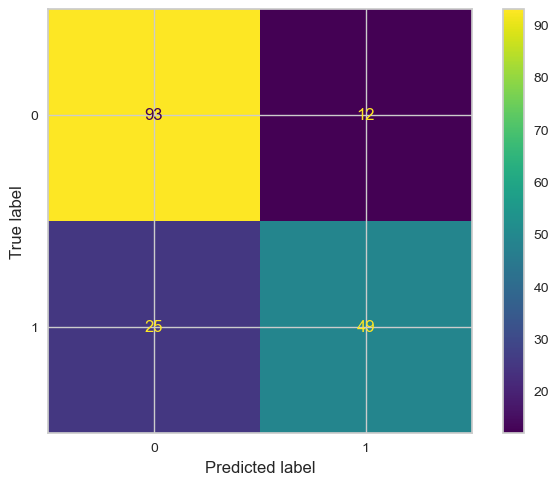

In [26]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test_final)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

<Axes: >

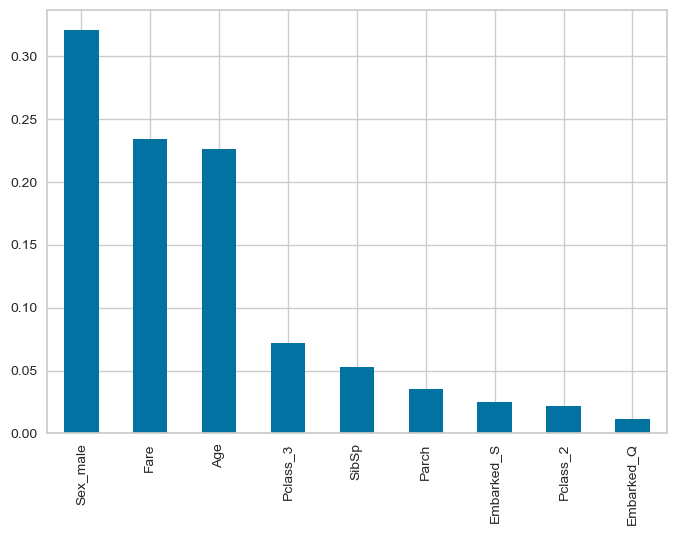

In [27]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_test_final.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar()

#### 2.3 Decision Tree

In [28]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train_final,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test_final)


In [29]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.7597765363128491


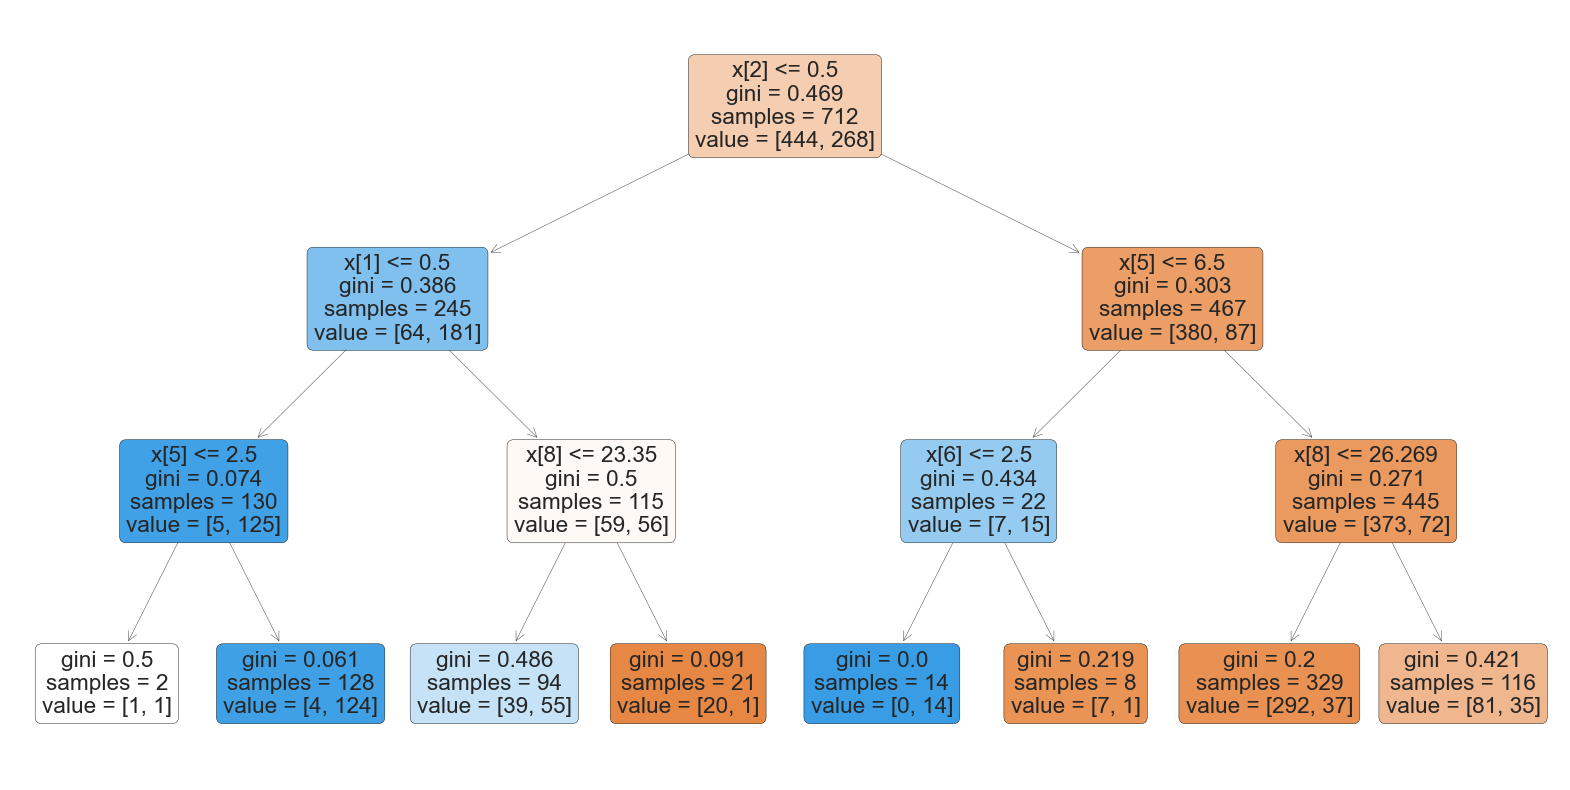

In [30]:

# Create Decision Tree classifer object with max_depth=3
clf = DecisionTreeClassifier(max_depth=3)

# Train Decision Tree Classifer
clf = clf.fit(X_train_final, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test_final)

# Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(clf, filled=True, rounded=True)
plt.show()

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Mejores parámetros encontrados:
{'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       105
           1       0.80      0.69      0.74        74

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179

Exactitud:
0.7988826815642458


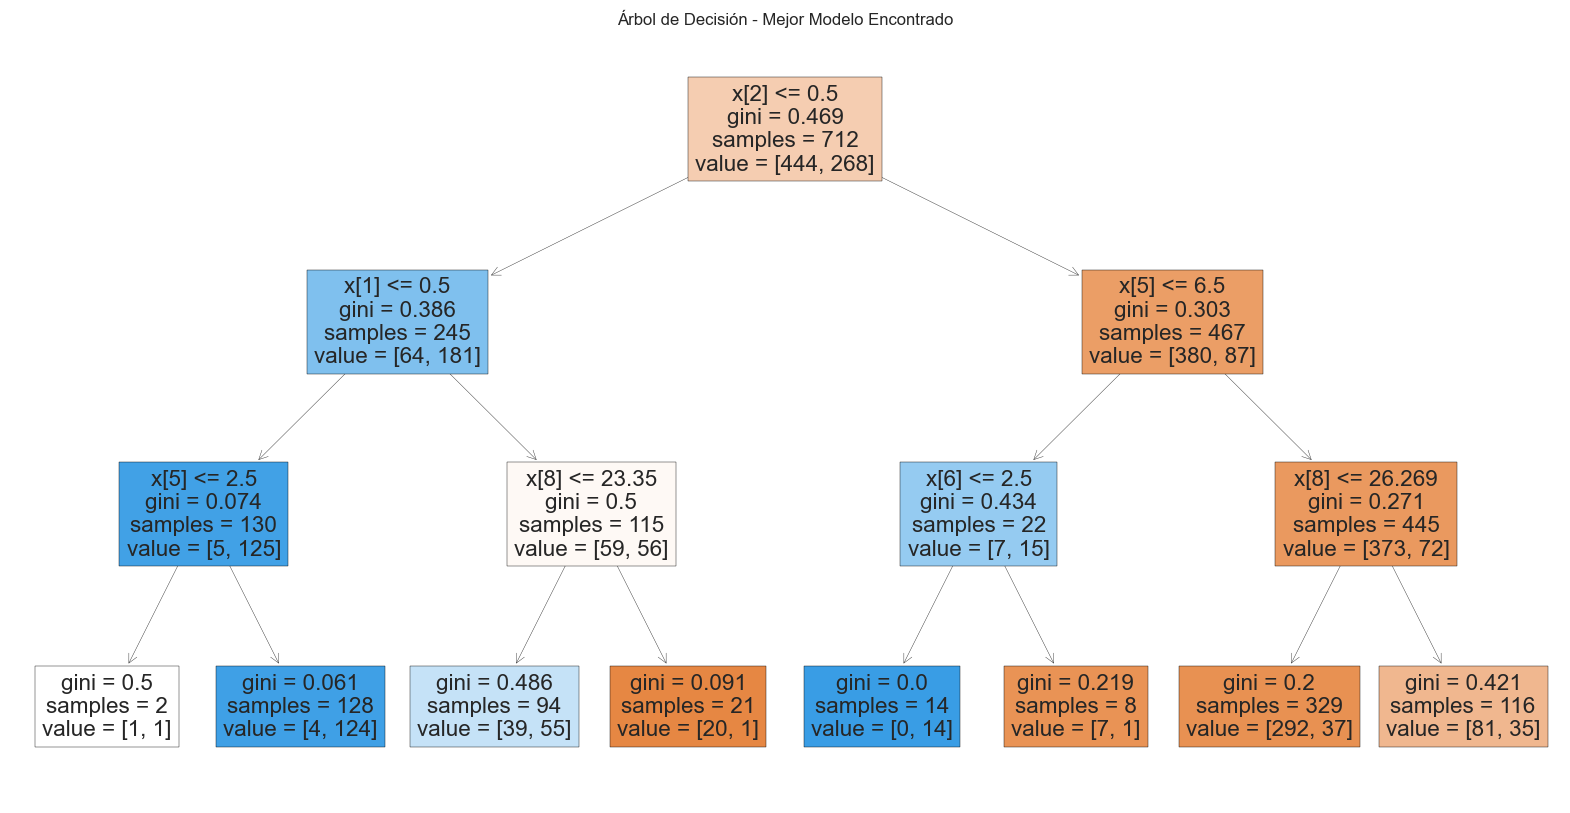

In [31]:

# Paso 3: Definir el modelo
dt = DecisionTreeClassifier()

# Paso 4: Definir los hiperparámetros a probar
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 2, 3, 4, 5,10],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}

# Paso 5: Realizar la búsqueda en cuadrícula
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_final, y_train)

# Paso 6: Obtener los mejores parámetros y evaluar el modelo
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_final)

print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))

print("Exactitud:")
print(accuracy_score(y_test, y_pred))
# Paso 7: Graficar el mejor árbol de decisión
plt.figure(figsize=(20,10))
plot_tree(best_model,filled=True)
plt.title("Árbol de Decisión - Mejor Modelo Encontrado")
plt.show()

### 3. Reducción de dimensionalidad

In [32]:
# Entrenamiento modelo PCA con escalado de los datos

# ==============================================================================
pca_pipe = make_pipeline(StandardScaler(), PCA())
pca_pipe.fit(pd.concat([X_train_final,y_train], axis=1))

# Se extrae el modelo entrenado del pipeline
modelo_pca = pca_pipe.named_steps['pca']

------------------------------------------
Porcentaje de varianza explicada acumulada
------------------------------------------
[0.20974972 0.38962887 0.52725812 0.64051468 0.74961951 0.82011593
 0.88705539 0.94106993 0.98111776 1.        ]


Text(0, 0.5, 'Por. varianza acumulada')

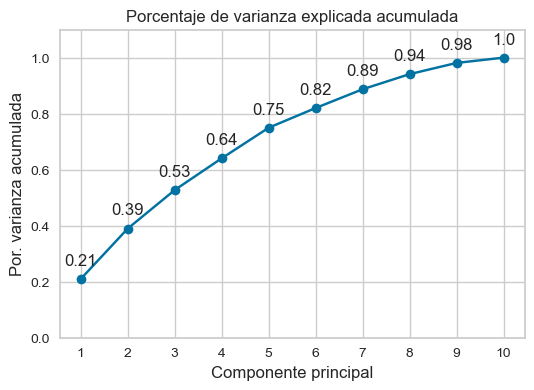

In [33]:

datos=pd.concat([X_train_final,y_train], axis=1)
# Porcentaje de varianza explicada acumulada
# ==============================================================================
prop_varianza_acum = modelo_pca.explained_variance_ratio_.cumsum()
print('------------------------------------------')
print('Porcentaje de varianza explicada acumulada')
print('------------------------------------------')
print(prop_varianza_acum)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.plot(
    np.arange(len(datos.columns)) + 1,
    prop_varianza_acum,
    marker = 'o'
)

for x, y in zip(np.arange(len(datos.columns)) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )
    
ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada')

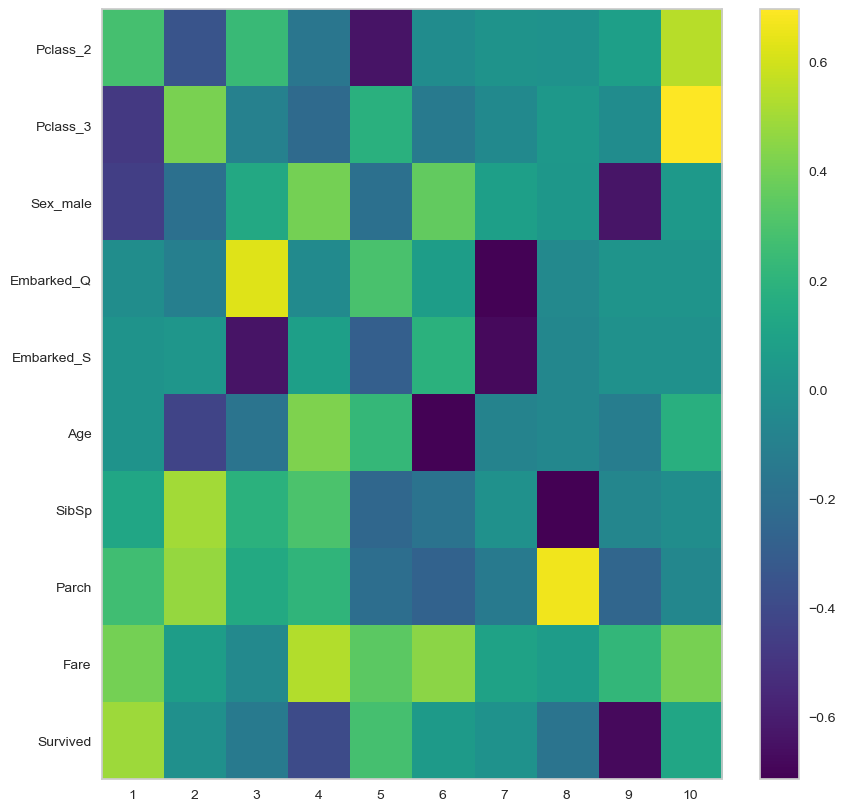

In [34]:
# Heatmap componentes
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
componentes = modelo_pca.components_
plt.imshow(componentes.T, cmap='viridis', aspect='auto')
plt.yticks(range(len(datos.columns)), datos.columns)
plt.xticks(range(len(datos.columns)), np.arange(modelo_pca.n_components_) + 1)
plt.grid(False)
plt.colorbar();

In [35]:
proyecciones = pca_pipe.transform(X=datos)
proyecciones = pd.DataFrame(
    proyecciones,
    columns = ['PC1', 'PC2', 'PC3', 'PC4','PC5','PC6','PC7','PC8','PC9', 'PC10'],
    index   = datos.index
)
proyecciones=proyecciones.iloc[:,:5]
proyecciones.head()

,PC1,PC2,PC3,PC4,PC5
331,-0.526923,-1.376834,0.418884,1.052475,0.479905
733,0.020864,-1.530995,1.315210,-0.204707,-1.575010
382,-1.751243,-0.569146,2.888221,-0.185968,1.634510
704,-1.537767,0.524356,-0.638418,0.190700,-0.407100
813,0.531239,4.015746,1.452734,0.082276,-0.759275


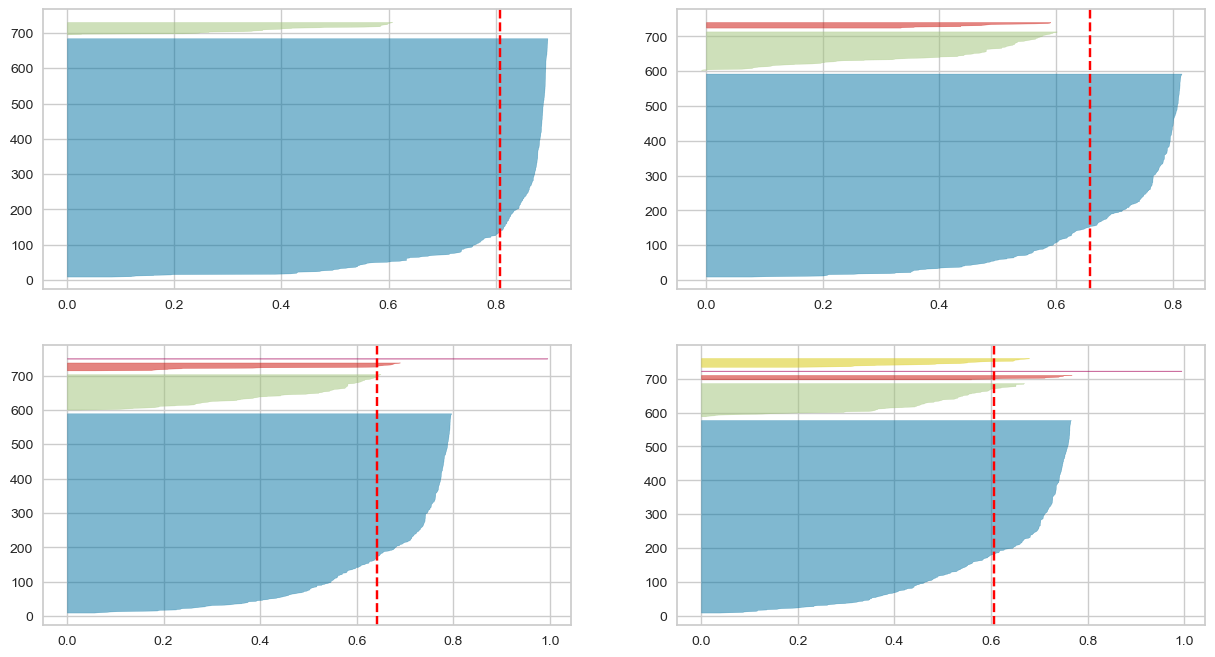

In [36]:
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(datos) #Vemos que el valor óptimo es K=2

### 4. Caracterización de los pasajeros

In [37]:

km = KMeans(n_clusters=2 ,init='k-means++', max_iter=300, n_init=10, random_state=0)
#
# Fit the KMeans model
#
km.fit_predict(datos)
#
# Calculate Silhoutte Score
#
score = silhouette_score(datos, km.labels_, metric='euclidean')
#
# Print the score
#
print('Silhouetter Score: %.3f' % score)
cluster_labels = km.fit_predict(datos)
cluster_label_mapping = {
    0: 'Cluster 1',
    1: 'Cluster 2',
    # Agregar más etiquetas según sea necesario para tus datos
}


# Agregar una nueva columna con las etiquetas de los clusters al DataFrame
df_train['Cluster_Labels'] = cluster_labels

# Aplicar el mapeo a la columna 'Cluster_Labels' utilizando el método map
df_train['Cluster_Labels'] = df_train['Cluster_Labels'].map(cluster_label_mapping)
# Mostrar las primeras filas del DataFrame para verificar que se ha agregado la columna
print(df_train.head())


Silhouetter Score: 0.808
    Survived Pclass     Sex   Age  SibSp  Parch     Fare Embarked  \
331        0      1    male  45.5    0.0    0.0  28.5000        C   
733        0      2    male  23.0    0.0    0.0  13.0000      NaN   
382        0      3    male  32.0    0.0    0.0   7.9250        Q   
704        0      3    male  26.0    1.0    0.0   7.8542        S   
813        0      3  female   6.0    4.0    2.0  31.2750      NaN   

    Cluster_Labels  
331      Cluster 2  
733      Cluster 2  
382      Cluster 2  
704      Cluster 2  
813      Cluster 2  


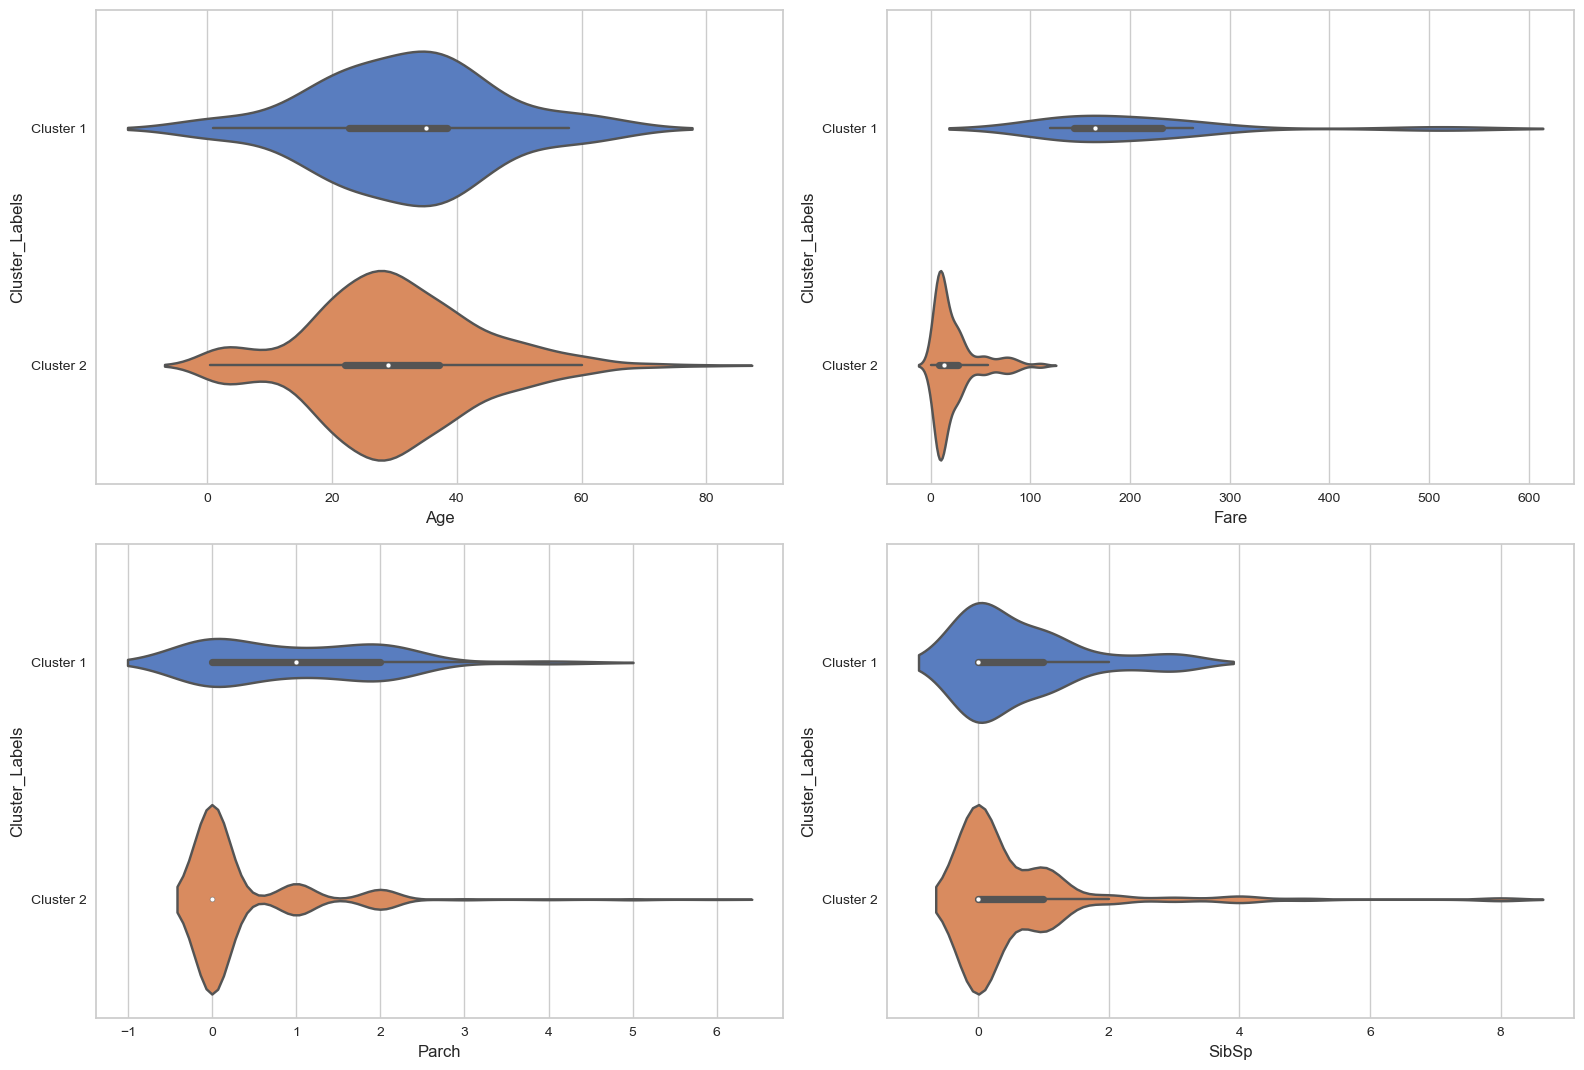

In [38]:
# Visualización de las variables cuantitativas vs Survived
df_train['Cluster_Labels'] = df_train['Cluster_Labels'].astype('category')

# Definir las variables cualitativas y cuantitativas
qualitative_cols = ['Sex', 'Embarked']
quantitative_cols = ['Age', 'Fare', 'Parch', 'SibSp']

# Crear un tablero para gráficos de violín de variables cuantitativas
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
fig.suptitle('', fontsize=16)

for i, col in enumerate(quantitative_cols):
    ax = axes[i // 2, i % 2]
    sns.violinplot(y='Cluster_Labels', x=col, data=df_train, ax=ax, palette="muted")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



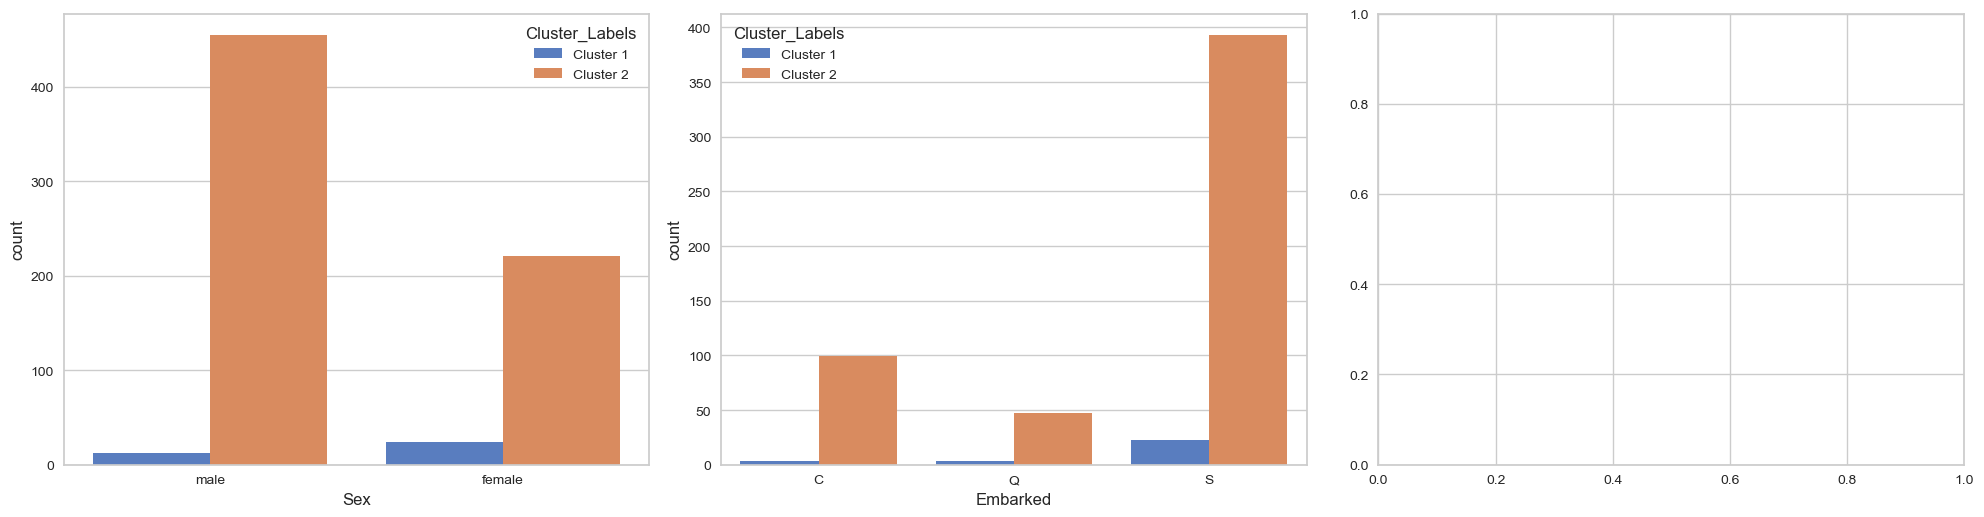

In [39]:
# Visualización de variables cualitativas vs Survived
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
fig.suptitle('', fontsize=16)

for i, col in enumerate(qualitative_cols):
    ax = axes[i]
    sns.countplot(x=col, hue='Cluster_Labels', data=df_train, ax=ax, palette="muted")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


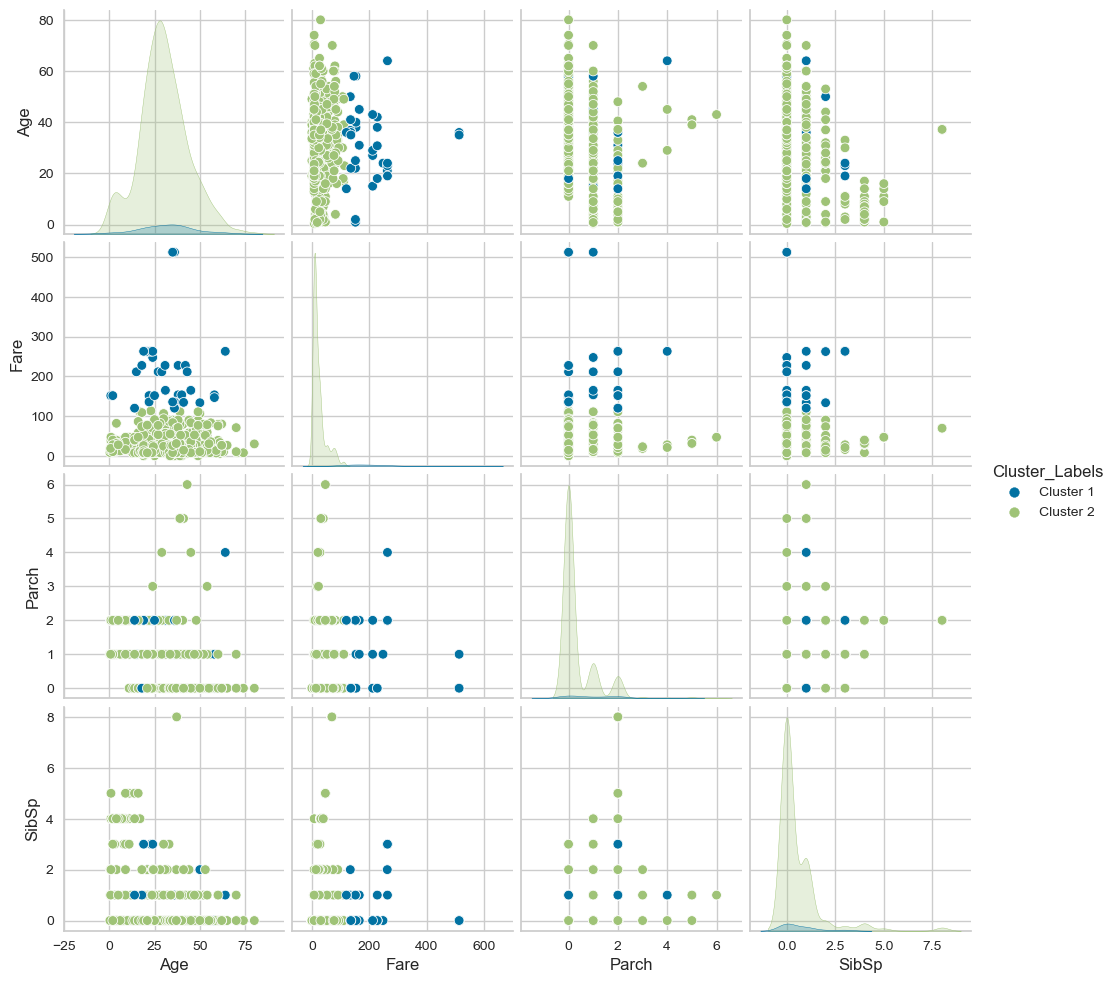

In [40]:
sns.pairplot(data=df_train[['Age', 'Fare', 'Parch', 'SibSp','Cluster_Labels']], hue="Cluster_Labels")